# Моделирование распределения доходностей финансовых активов и оценка опционов

Написание алгоритма моделирования доходностей финансовых активов и оценки опционов начинаем с импорта библиотек

In [97]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop # Необходим для численной оптимизации при использовании метода максимального правдоподобия
import matplotlib.pyplot as plt
import datetime
import random

Здесь появлялась ошибка синтаксиса, которая лечилась добавлением двойной косой черты "\\"

In [98]:
# Экспортируем котировки фьючерса на индекс РТС. Данные взяты отсюда: https://www.finam.ru/profile/mosbirzha-fyuchersy/rts/export/
raw_data = pd.read_csv('E:\\repo\\valuation_of_options\\rts_9-23\\Si-12.23_30-10-2023.csv')
raw_data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SiZ3 [SPBFUT],Daily,20211213,0,85455.0,85766.0,85455.0,85600.0,9.0
1,SiZ3 [SPBFUT],Daily,20211214,0,85250.0,85250.0,85250.0,85250.0,1.0
2,SiZ3 [SPBFUT],Daily,20211215,0,86000.0,86370.0,86000.0,86110.0,6.0
3,SiZ3 [SPBFUT],Daily,20211217,0,86390.0,86690.0,86390.0,86393.0,6.0
4,SiZ3 [SPBFUT],Daily,20211220,0,86607.0,86658.0,86598.0,86658.0,6.0


In [99]:
# Получаем общие сведения о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  473 non-null    object 
 1   <PER>     473 non-null    object 
 2   <DATE>    473 non-null    int64  
 3   <TIME>    473 non-null    int64  
 4   <OPEN>    473 non-null    float64
 5   <HIGH>    473 non-null    float64
 6   <LOW>     473 non-null    float64
 7   <CLOSE>   473 non-null    float64
 8   <VOL>     473 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 33.4+ KB


In [100]:
# Здесь мне надо было убедиться, что данные являются датафреймом
type(raw_data)

pandas.core.frame.DataFrame

In [101]:
# Доходность получаем следующим образом
raw_data['return'] = (raw_data['<CLOSE>'] - raw_data['<OPEN>']) / raw_data['<OPEN>']
raw_data['return'].head()

0    0.001697
1    0.000000
2    0.001279
3    0.000035
4    0.000589
Name: return, dtype: float64

In [102]:
# ранжируем наблюдения от меньших к большим и вычислим эмпирическую функцию распределения
raw_data['rank'] = (raw_data['return'].rank(method='first'))/(len(raw_data))
raw_data = raw_data.sort_values(by='rank').reset_index(drop=True)

In [103]:
# Вычислим наиболее важные описательные статистики эмпирического распределения
mean = np.average(raw_data['return']) # средняя доходность
med = np.median(raw_data['return']) # медианная доходность
std = np.std(raw_data['return']) # Стандартное отклонение
var = std**2 # Дисперсия
skew = sps.skew(raw_data['return']) # Скошенность
kurt = sps.kurtosis(raw_data['return']) # Эксцесс

**Среднее абсолютное отклонение**, или просто **среднее отклонение** (англ. MAD, mean absolute deviation) - величина, используемая для оценки прогнозных функций:

$MAD=\frac{1}{n}\displaystyle\sum_{i=1}^{n} |{x}_{i}-m(X)|$


In [104]:
# Оценим параметры распределения Лапласа методом максимального правдоподобия
loc_laplace = med # параметр локации Лапласа это просто медиана
scale_laplace = np.average(abs(raw_data['return'] - med)) # Параметр масштаба Лапласа - это среднее абсолютное отклонение

In [105]:
# Оценим параметры распределения Коши методом моментов
loc_cauchy = med
scale_cauchy = (np.percentile(raw_data['return'], 0.75) - np.percentile(raw_data['return'], 0.25))/2

In [106]:
# Оценим параметры распределения Koши методом максимального правдоподобия
def cauchy_mle(k):
    return -np.sum(np.log(1/(np.pi*k[1]*(1 + ((raw_data['return'] - k[0])/k[1])**2))))
res = spop.minimize(cauchy_mle, [loc_cauchy, scale_cauchy], method='Powell')
loc_cauchy_mle = res.x[0]
scale_cauchy_mle = res.x[1]

e:\repo\valuation_of_options\virtenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
# Оценим параметры гипреболического секанта методом максимального правдоподобия
def hypersecant_mle(k):
    return -np.sum(np.log(np.pi/k[1])*np.exp(np.pi/2*(raw_data['return'] - k[0])/k[1])/(1 + np.exp(np.pi * (raw_data['return'] - k[0])/k[1])))
res = spop.minimize(hypersecant_mle, [mean, std], method='Powell')
loc_hypersecant_mle = res.x[0]
scale_hypersecant_mle = res.x[1]

C:\Users\Pro\AppData\Local\Temp\ipykernel_22516\998792672.py:3: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(np.pi/k[1])*np.exp(np.pi/2*(raw_data['return'] - k[0])/k[1])/(1 + np.exp(np.pi * (raw_data['return'] - k[0])/k[1])))


In [108]:
# Оценим параметры логистического распределения методом моментов
loc_logistic = mean
scale_logistic = 3**(1/2)/np.pi*std

In [109]:
# Оценим параметры логистического распределения методом максимального правдоподобия
def logistic_mle(k):
    return -np.sum(np.log(np.exp(-(raw_data['return'] - k[0])/k[1])/(k[1]*(1+np.exp(-(raw_data['return'] - k[0])/k[1]))**2)))
res = spop.minimize(logistic_mle, [loc_logistic, scale_logistic], method='Powell')
loc_logistic_mle = res.x[0]
scale_logistic_mle = res.x[1]

In [110]:
# Оценим параметры распределения Стьюдента методом моментов
df_student = 6/kurt + 4
loc_student = mean
scale_student = std*((df_student - 2)/df_student)**(1/2)

##### Распределение Лапласа (двойное экспоненциальное, двойное показательное)
Функция распределения:

$F(x) = \begin{cases}\frac{1}{2}e^{(\frac{x-m}{b})}, x \leq m\\1-\frac{1}{2}e^{-\frac{x-m}{b}}, x > m\end{cases}$

где $x$ - доходность

$m$ - медианная доходность

$b$ - среднее абсолютное отклонение

Функция плотности вероятности:

$f(x)=\frac{1}{2b}e^{-\frac{|x-m|}{b}}$

Эксцесс = 3

Оценка параметров методом максимального правдоподобия (ММП): медиана и среднее абсолютное отклонение

In [111]:
# Выведем теоретические функции распределения исходя из оценённых параметров
raw_data['Нормальное'] = sps.norm.cdf(raw_data['return'], loc=mean, scale=std)
raw_data['Коши-ММ'] = 1/np.pi*np.arctan((raw_data['return'] - loc_cauchy)/scale_cauchy) + 1/2
raw_data['Коши-ММП'] = 1/np.pi*np.arctan((raw_data['return'] - loc_cauchy_mle)/scale_cauchy_mle) + 1/2
raw_data['Лаплас1'] = 1/2 * np.exp((raw_data[raw_data['return']<=loc_laplace]['return']-med)/scale_laplace)
raw_data['Лаплас2'] = 1-1/2*np.exp(-(raw_data[raw_data['return']>med]['return']-loc_laplace)/scale_laplace)
raw_data['Лаплас'] = raw_data['Лаплас1'].replace(np.nan, 0) + raw_data['Лаплас2'].replace(np.nan, 0)
raw_data['Гиперсекант-ММ'] = 2/np.pi*np.arctan(np.exp(np.pi*(raw_data['return']-mean)/(2*std)))
raw_data['Гиперсекант-ММП'] = 2/np.pi*np.arctan(np.exp(np.pi*(raw_data['return']-loc_hypersecant_mle)/(2*scale_hypersecant_mle)))
raw_data['Стьюдент'] = sps.t.cdf((raw_data['return']-loc_student)/(scale_student), df_student, loc=0, scale=1)
raw_data['Логистическое-ММ'] = 1/(1+np.exp(-(raw_data['return']-loc_logistic)/scale_logistic))
raw_data['Логистическое-ММП'] = 1/(1+np.exp(-(raw_data['return']-loc_logistic_mle)/scale_logistic_mle))


Нормальное

Супремум равен: 0.1089
p-значение равно: 0.0037
Распределение не подходит


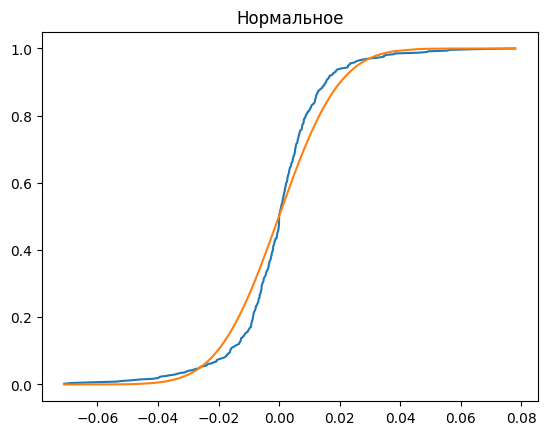


Лаплас

Супремум равен: 0.0354
p-значение равно: 0.5519
Распределение подходит


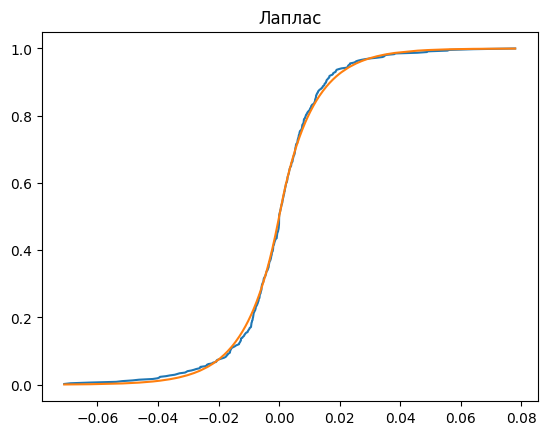


Гиперсекант-ММ

Супремум равен: 0.0713
p-значение равно: 0.0904
Распределение не подходит


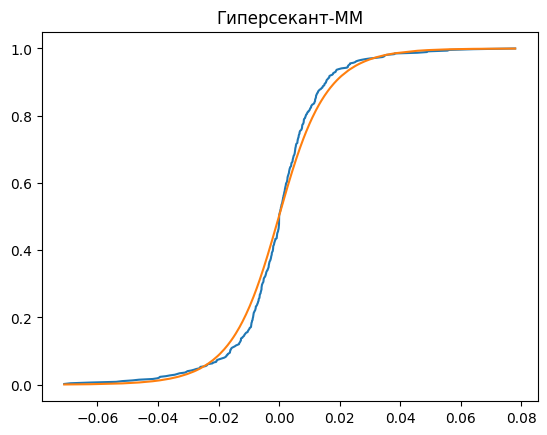


Гиперсекант-ММП

Супремум равен: 0.1783
p-значение равно: 0.0
Распределение не подходит


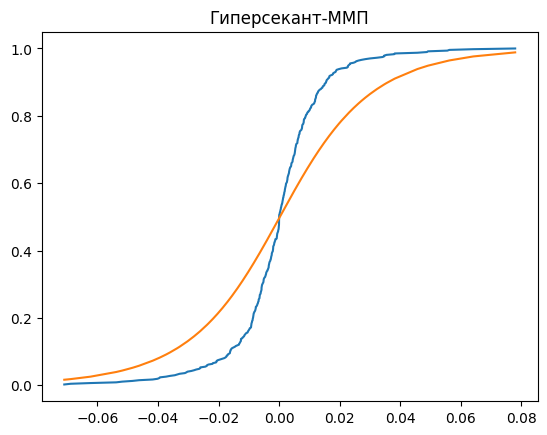


Коши-ММ

Супремум равен: 0.0558
p-значение равно: 0.2299
Распределение подходит


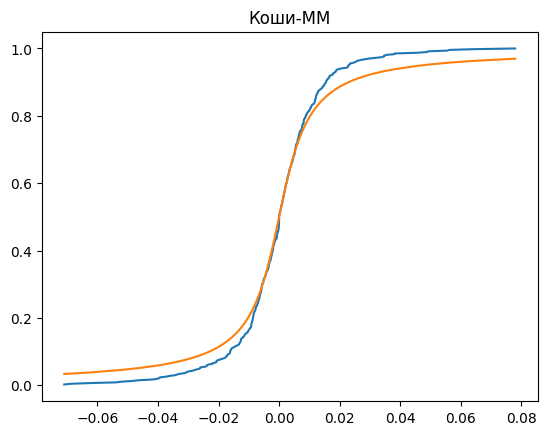


Коши-ММП

Супремум равен: 0.0425
p-значение равно: 0.4254
Распределение подходит


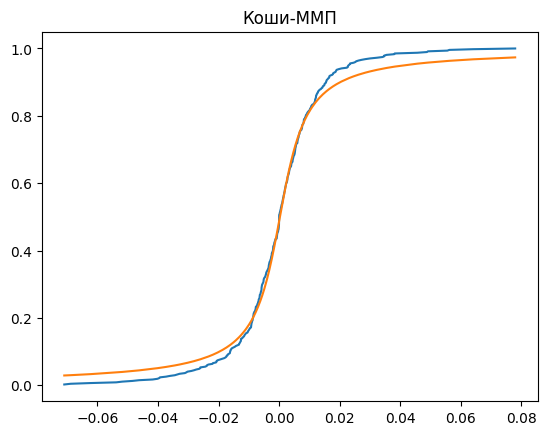


Стьюдент

Супремум равен: 0.0747
p-значение равно: 0.0716
Распределение не подходит


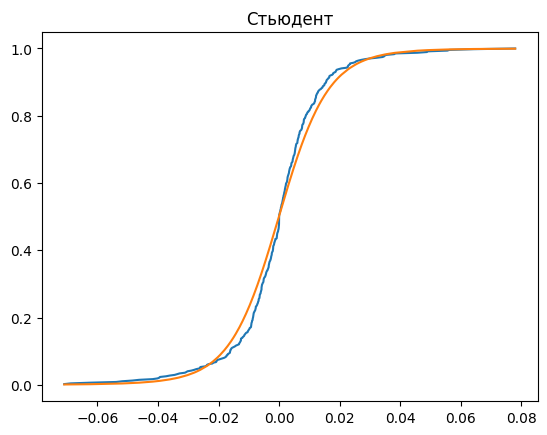


Логистическое-ММ

Супремум равен: 0.0867
p-значение равно: 0.0285
Распределение не подходит


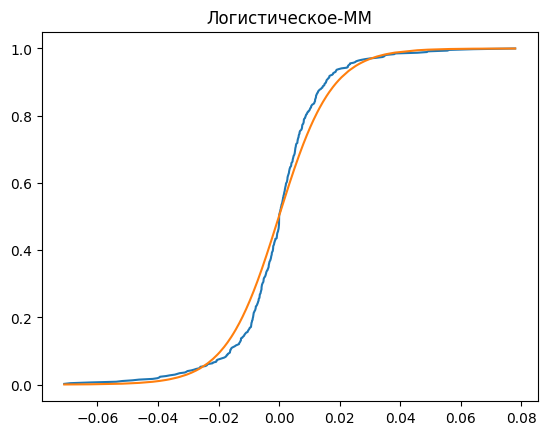


Логистическое-ММП

Супремум равен: 0.0579
p-значение равно: 0.2043
Распределение подходит


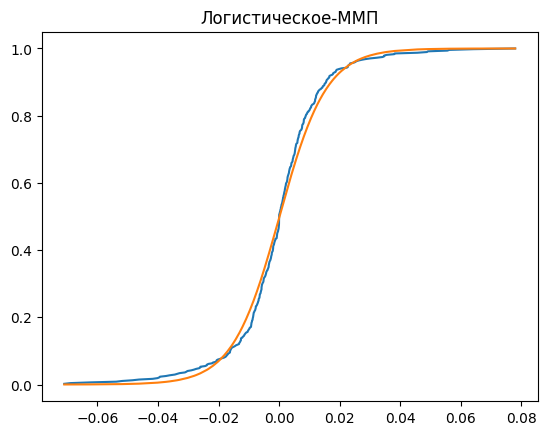

In [112]:
# Сравним теоретические функции распределения с эмпирическими для каждого распределения
distributions = [
	"Нормальное",
	"Лаплас",
	"Гиперсекант-ММ",
	"Гиперсекант-ММП",
	"Коши-ММ",
	"Коши-ММП",
	"Стьюдент",
	"Логистическое-ММ",
	"Логистическое-ММП",
]
for dist in distributions:
	
	# Вычислим супремум (статистику Колмогорова-Смирнова)
	KS_array = abs(raw_data["rank"] - raw_data[dist])
	KS = max(KS_array)
	
	# вычислим р-значения (вероятность, с которой данные подчиняются этому распределению)
	KS_p = np.exp(-(KS**2) * len(raw_data))
	
	# визуализируем результат и выведем результаты теста Колмогорова-Смирнова
	print()
	print(dist)
	print()
	print('Супремум равен: ' + str(round(KS, 4)))
	print('p-значение равно: ' + str(round(KS_p, 4)))
	
	if KS_p > 0.1:
		print('Распределение подходит')
	else:
		print('Распределение не подходит')
	plt.figure(dist)
	plt.plot(raw_data['return'], raw_data['rank'])
	plt.plot(raw_data['return'], raw_data[dist])
	plt.title(dist)
	plt.show()

In [113]:
# Введем характеристики стратегии

start_price = 95211.0 # стартовая цена, т.е. текущая цена базового актива
start_dt = datetime.date(2023, 10, 31) # стартовая дата
end_dt = datetime.date(2023, 11, 2) # дата экспирации
expiry = (end_dt - start_dt).days # число дней от начала торгов до даты экспирации
maturity = expiry/365 # срочность
t_days = int(maturity*252) # сколько торговых дней между началом стратегии и экспирацией
strike = 94000.0 # цена страйк
call_bid = 1234.0 # 
call_ask = 1326.0 #
put_bid = 102.0 #
put_ask = 103.0 #
end_price = 94244.0 #

drift = (1+mean)**252-1 # годовая ожидаемая доходность
vol = std*(252)**(1/2) #

In [114]:
# определим функцию симуляции опционной стратегии
def strategy_simulation(k):
    payoff = 0
    print()
    print('Справедливая стоимость опциона колл равна ' + str(round(k[0], 4)))
    if k[0] > call_ask:
        print('Используем стратегию лонг колл')
        payoff += max(0, end_price - strike) - call_ask
    elif k[0] < call_bid:
        print('Используем стратегию шорт колл')
        payoff += call_bid - max(0, end_price - strike)
    else:
        print('Стратегии на основе опциона call невыгдны')
    print()
    print('Справедливая стоимость опциона put равна ' + str(round(k[1], 4)))
    if k[1] > put_ask:
        print('Используем стратегию long put')
        payoff += max(0, strike - end_price) - put_ask
    elif k[1] < put_bid:
        print('Используем стратегию short put')
        payoff += put_bid - max(0, strike - end_price)
    else:
        print('Стратегии на основе опциона put невыгодны')
    print()
    if payoff >= 0:
        print('Вы заработали ' + str(round(payoff, 4)) + ' долларов на акцию')
    else:
        print('Вы потеряли ' + str(round(abs(payoff), 4)) + ' долларов на акцию')
    print()

In [115]:
# Оценим опционы с помощью модели Блэка-Шоулза
d1 = (np.log(start_price/strike)+(drift+vol**2/2)*maturity)/(vol*maturity**(1/2))
d2 = (np.log(start_price/strike)+(drift-vol**2/2)*maturity)/(vol*maturity**(1/2))

In [116]:
# Нормальное распределение

call_value = start_price*sps.norm.cdf(d1, loc=0, scale=1) - strike*np.exp(-drift*maturity)*sps.norm.cdf(d2, loc=0, scale=1)
put_value = -start_price*sps.norm.cdf(-d1, loc=0, scale=1) + strike*np.exp(-drift*maturity)*sps.norm.cdf(-d2, loc=0, scale=1)

print()
print('Блэк-Шоулз, нормальное распрелеление')
strategy_simulation([call_value, put_value])


Блэк-Шоулз, нормальное распрелеление

Справедливая стоимость опциона колл равна 1462.8348
Используем стратегию лонг колл

Справедливая стоимость опциона put равна 258.8278
Используем стратегию long put

Вы потеряли 1185.0 долларов на акцию



In [117]:
# Оценим опционы с помощью метода Монте-Карло

# Нормальное распределение

# Симулируем 1000 сценариев
n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	# Симулируем движение акции на протяжении всех торговых дней вплоть до экспирации
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = sps.norm.ppf(prob, loc=mean, scale=std)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
# Ценность опциона - ожидаемый выигрыш
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, нормальное распределение')
strategy_simulation([call_value, put_value])


Монте-Карло, нормальное распределение

Справедливая стоимость опциона колл равна 1308.9222
Стратегии на основе опциона call невыгдны

Справедливая стоимость опциона put равна 151.3998
Используем стратегию long put

Вы потеряли 103.0 долларов на акцию



In [118]:
# Стьюдент

n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = mean + std*sps.t.ppf(prob, df_student)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Стьюдента')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Стьюдента

Справедливая стоимость опциона колл равна 1331.687
Используем стратегию лонг колл

Справедливая стоимость опциона put равна 240.9858
Используем стратегию long put

Вы потеряли 1185.0 долларов на акцию



In [119]:
# Коши

n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = loc_cauchy_mle + scale_cauchy_mle*np.tan(np.pi*prob - np.pi/2)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Коши')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Коши

Справедливая стоимость опциона колл равна 1507.9805
Используем стратегию лонг колл

Справедливая стоимость опциона put равна 417.8349
Используем стратегию long put

Вы потеряли 1185.0 долларов на акцию



In [120]:
# Лаплас
# Симулируем 1000 сценариев
n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	# Симулируем движение акции на протяжении всех торговых дней вплоть до экспирации
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = sps.laplace.ppf(prob, loc=mean, scale=std)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
# Ценность опциона - ожидаемый выигрыш
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Лапласа')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Лапласа

Справедливая стоимость опциона колл равна 1479.4959
Используем стратегию лонг колл

Справедливая стоимость опциона put равна 283.8791
Используем стратегию long put

Вы потеряли 1185.0 долларов на акцию

